In [93]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from utils import *
from env import Environment
from main import Config
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patheffects as path_effects


# Baseline: Fictitious Play Solving Two-Agents Dilemma
Payoff matrix:

| Tables      | Cooperation |  Defection |
|-------------|:-----------:|-----------:|
| Cooperation |   REWARD    | TEMPTATION |
| Defection   |   SUCKER    | PUNISHMENT |

In [2]:
N_EPISODES = 100
EPOCH = 100
seed = 42
np.random.seed(seed)

In [214]:
from scipy.stats import binom

R, T, S, P = 2, 1.5, -1, 0
print(R+S-T-P)
Pr = 0
for i in range(11):
    print(i, binom.cdf(i, 10, 0.5))
    if (R+S) * binom.cdf(i, 10, 0.5) < (T+P) * (1-binom.cdf(i, 10, 0.5)):
        Pr = binom.cdf(i, 10, 0.5)
        print(i, Pr)

-0.5
0 0.0009765625
0 0.0009765625
1 0.0107421875
1 0.0107421875
2 0.0546875
2 0.0546875
3 0.171875
3 0.171875
4 0.376953125
4 0.376953125
5 0.623046875
6 0.828125
7 0.9453125
8 0.9892578125
9 0.9990234375
10 1.0


In [216]:
print((R+S) * binom.cdf(4, 10, 0.5) - (T+P) * (1-binom.cdf(4, 10, 0.5)))
print((R+S) * binom.cdf(5, 10, 0.5) - (T+P) * (1-binom.cdf(5, 10, 0.5)))

-0.5576171875
0.0576171875


In [3]:
def two_agent_fictitious_play(payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, epsilon:float=0.05, random:bool=False):
    # exploration
    for i in range(1,10):
        strategy[i,0] = np.random.randint(0,2)
        strategy[i,1] = np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

    for i in range(10,N_EPISODES):
        # calculate payoff of Agent 0 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[i-1,1]*payoff[0,1] + (1-belief[i-1,1])*payoff[0,0]
        reward[1,0] = belief[i-1,1]*payoff[1,1] + (1-belief[i-1,1])*payoff[1,0]

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[i-1,0]*payoff[0,1] + (1-belief[i-1,0])*payoff[0,0]
        reward[1,1] = belief[i-1,0]*payoff[1,1] + (1-belief[i-1,0])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,0] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,0] = 0
        else:
            strategy[i,0] = strategy[i-1,0] if random==False else np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,1] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,1] = 0
        else:
            strategy[i,1] = strategy[i-1,1] if random==False else np.random.randint(0,2)

        # update the empirical distribution
        belief[i,0] = ((i-1)*belief[i-1,0] + strategy[i,0])/i
        belief[i,1] = ((i-1)*belief[i-1,1] + strategy[i,1])/i

        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    return strategy, belief

In [4]:
# def generate_payoff_matrix(name:str, REWARD=3, TEMPTATION=None, SUCKER=None, PUNISHMENT=1, N=100):
#     # prisoner's dilemma rule: TEMPTATION > REWARD > PUNISHMENT > SUCKER; 2*REWARD > TEMPTATION + SUCKER
#     if REWARD is not None and TEMPTATION is not None and SUCKER is not None and PUNISHMENT is not None:
#         return REWARD, TEMPTATION, SUCKER, PUNISHMENT
#     if name == 'PD':
#         TEMPTATION = np.round(np.random.uniform(REWARD+0.01, 2*REWARD-0.01, N), decimals=2)
#         x = np.ones(N)
#         REWARD = REWARD * x
#         SUM = np.round(np.random.uniform(TEMPTATION, 2*REWARD-0.01, N), decimals=2)
#         SUCKER = SUM - TEMPTATION
#         PUNISHMENT = np.round(np.random.uniform(SUCKER+0.01, REWARD-0.01, N), decimals=2)
#         assert np.sum(TEMPTATION > REWARD) == N and np.sum(REWARD > PUNISHMENT) == N and np.sum(PUNISHMENT > SUCKER) == N, f'{np.sum(TEMPTATION > REWARD)} and {np.sum(REWARD > PUNISHMENT)} and {np.sum(PUNISHMENT > SUCKER)}'
#         assert np.sum(2*REWARD > TEMPTATION + SUCKER) == N, f'{np.sum(2*REWARD > TEMPTATION + SUCKER)}'
#         return REWARD, TEMPTATION, SUCKER, PUNISHMENT
#     if name == 'SH':
#         # stag hunt rule: REWARD > TEMPTATION > PUNISHMENT > SUCKER; TEMPTATION + SUCKER > 2*PUNISHMENT
#         x = np.ones(N)
#         PUNISHMENT = PUNISHMENT * x
#         SUCKER = np.round(np.random.uniform(0, PUNISHMENT-0.01, N), decimals=2)
#         TEMPTATION = np.round(np.random.uniform(2*PUNISHMENT-SUCKER+0.01, 10-0.01, N), decimals=2)
#         REWARD = np.round(np.random.uniform(TEMPTATION+0.01, 10, N), decimals=2)
#         assert np.sum(REWARD > TEMPTATION) == N and np.sum(TEMPTATION > PUNISHMENT) == N and np.sum(PUNISHMENT > SUCKER) == N, f'{np.sum(REWARD > TEMPTATION)} and {np.sum(TEMPTATION > PUNISHMENT)} and {np.sum(PUNISHMENT > SUCKER)}'
#         return REWARD, TEMPTATION, SUCKER, PUNISHMENT

def two_agent_simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT):
    # C:0, D:1
    df_result = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, S, T, P = val, SUCKER[idx], TEMPTATION[idx], PUNISHMENT[idx]
        payoff = np.array([[R, S],[T, P]])
        strategy_list, belief_list = [],[]
        for ep in range(EPOCH):
            # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
            reward = np.zeros([2,2])
            # 'strategy' stores the strategy played in each time period
            strategy = -np.ones([N_EPISODES,2])
            # 'belief' stores the empirical distribution at each time period, which is the defection probability
            belief = np.zeros([N_EPISODES,2])
            strategy, belief = two_agent_fictitious_play(payoff, reward, strategy, belief, epsilon=0)
            strategy_list.append(strategy[-1].copy())
            belief_list.append(belief[-1].copy())
        df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=['Agent_1', 'Agent_2', 'Agent_1_Belief', 'Agent_2_Belief'])
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_result = pd.concat([df_result, df_mean], ignore_index=True)
    return df_result.astype(float)

PD results

1000it [01:08, 14.62it/s]


<AxesSubplot:ylabel='Frequency'>

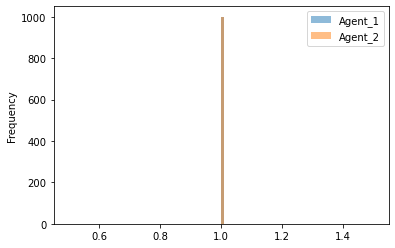

In [5]:
# prisoner's dilemma
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 5, 0, 1
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=1000)
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0
# payoff matrix for the two Agents in the 2x2 game
df_PD = two_agent_simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT)
df_PD[['Agent_1', 'Agent_2']].plot.hist(bins=100, alpha=0.5)

In [18]:
df_PD

,Agent_1,Agent_2,Agent_1_Belief,Agent_2_Belief,temptation,reward,punishment,sucker
0,1.0,1.0,0.954747,0.952626,1.15,1.0,0.0,-0.63
1,1.0,1.0,0.953434,0.954848,1.48,1.0,0.0,-0.06
2,1.0,1.0,0.954747,0.953333,2.08,1.0,0.0,-0.28
3,1.0,1.0,0.955354,0.955859,1.97,1.0,0.0,-0.41
4,1.0,1.0,0.955253,0.955556,2.45,1.0,0.0,-0.85
...,...,...,...,...,...,...,...,...
995,1.0,1.0,0.955859,0.953838,2.18,1.0,0.0,-0.91
996,1.0,1.0,0.954949,0.954444,2.02,1.0,0.0,-0.09
997,1.0,1.0,0.954747,0.955051,1.01,1.0,0.0,-0.86
998,1.0,1.0,0.953535,0.953636,1.01,1.0,0.0,-0.06


Text(0.5, 1.0, 'Belief Histogram')

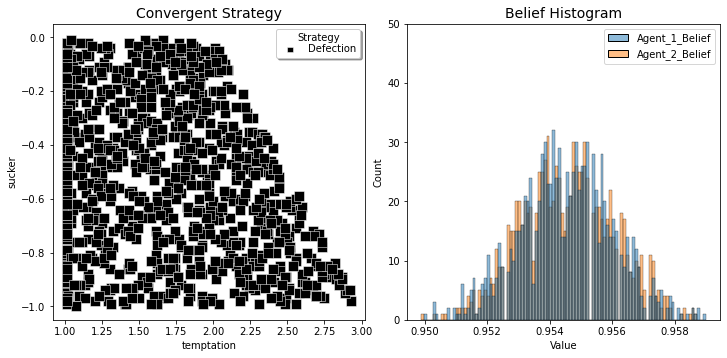

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
# sns.histplot(ax=axes[0], data=df_PD[['Agent_1', 'Agent_2']], alpha=0.5, bins=20)
sns.scatterplot(ax=axes[0], data=df_PD, y='sucker', x='temptation', 
                hue="Agent_1", size="Agent_1", sizes=[100], style='Agent_1', 
                markers=['s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=0')
lgnd = axes[0].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Strategy', markerscale=.4, 
           labels=['Defection'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
# axes[0].axis(ymin=-1.1,ymax=0.05)
axes[0].set_ylim(-1.05,.05)

sns.histplot(ax=axes[1], data=df_PD[['Agent_1_Belief', 'Agent_2_Belief']], alpha=0.5, bins=100)
axes[1].set_ylim(0,50)
axes[1].set_xlabel('Value')

axes[0].set_title('Convergent Strategy', fontsize=14)
axes[1].set_title('Belief Histogram', fontsize=14)

<AxesSubplot:ylabel='Count'>

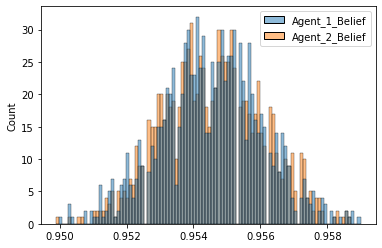

In [16]:
sns.histplot(data=df_PD[['Agent_1_Belief', 'Agent_2_Belief']], alpha=0.5, bins=100)

Stag Hunt result

In [17]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1

df_SH = two_agent_simulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT)
# df_SH[['Agent_1', 'Agent_2']].plot.hist(bins=100, alpha=0.5)

1000it [01:16, 13.15it/s]


In [129]:
df_SH['strategy'] = -1
df_SH.loc[df_SH.Agent_1 < 0.1, 'strategy'] = 0
df_SH.loc[df_SH.Agent_1 > 0.9, 'strategy'] = 1
df_SH.loc[(df_SH.Agent_1 < 0.9) & (df_SH.Agent_1 > 0.5), 'strategy'] = -0.5
df_SH

,Agent_1,Agent_2,Agent_1_Belief,Agent_2_Belief,temptation,reward,punishment,sucker,strategy,srategy,R+S-T-P
0,0.09,0.09,0.129192,0.127273,0.19,1.50,0.0,-0.81,0.0,0.0,0.50
1,0.00,0.00,0.044646,0.046061,0.54,3.80,0.0,-0.46,0.0,0.0,2.80
2,0.00,0.00,0.045657,0.044343,0.87,2.93,0.0,-0.13,0.0,0.0,1.93
3,0.00,0.00,0.046364,0.047273,0.73,2.39,0.0,-0.27,0.0,0.0,1.39
4,0.99,0.99,0.944848,0.945960,0.80,1.00,0.0,-0.58,1.0,1.0,-0.38
...,...,...,...,...,...,...,...,...,...,...,...
995,0.99,0.99,0.945556,0.943737,0.65,1.00,0.0,-0.98,1.0,1.0,-0.63
996,0.00,0.00,0.045859,0.045354,0.95,3.67,0.0,-0.05,0.0,0.0,2.67
997,0.79,0.79,0.763131,0.762626,0.08,1.00,0.0,-1.37,-0.5,NaN,-0.45
998,0.00,0.00,0.044545,0.044646,0.07,3.80,0.0,-0.93,0.0,0.0,2.80


Text(0.5, 1.0, 'Belief Histogram')

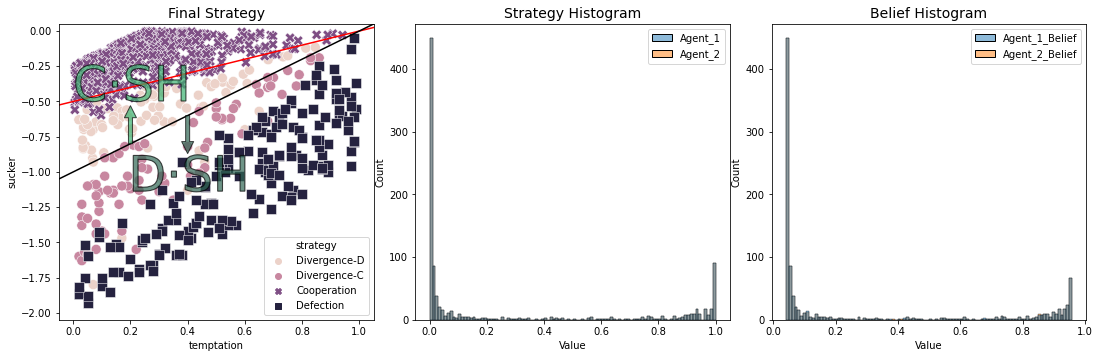

In [197]:
df_SH_plot = df_SH.copy()
df_SH_plot.temptation = df_SH_plot.temptation/df_SH_plot.reward
df_SH_plot.sucker = df_SH_plot.sucker/df_SH_plot.reward
df_SH_plot.reward = df_SH_plot.reward/df_SH_plot.reward
df_SH_plot = df_SH_plot.sort_values(by=['strategy'],ascending=True)
df_SH_plot.loc[df_SH_plot.strategy == 0, 'strategy'] = 'Cooperation'
df_SH_plot.loc[df_SH_plot.strategy == 1, 'strategy'] = 'Defection'
df_SH_plot.loc[df_SH_plot.strategy == -0.5, 'strategy'] = 'Divergence-C'
df_SH_plot.loc[df_SH_plot.strategy == -1, 'strategy'] = 'Divergence-D'

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
sns.scatterplot(ax=axes[0], data=df_SH_plot, y='sucker', x='temptation', 
                hue="strategy", s=100, style='strategy', 
                markers=['o','o','X','s'], linewidth=0.5, alpha=1, legend="full", palette='ch:s=-.2,r=.5')
# axes[0].legend(title='Strategy', loc='lower right', labels=['Divergence_D','Divergence_C','Defection','Cooperation'])
# lgnd = axes[0].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Strategy', markerscale=.4, 
#            labels=['Defection','Divergence_D','Divergence_C','Cooperation'], loc='lower right', shadow=True)
# for i in lgnd.legendHandles:
#     i._sizes = [30]

x = np.linspace(-0.1, 1.1, 100)
y = -0.5 + 0.5* x 
axes[0].plot(x, y, "r")
# y = -1.5 + 1.5*x
# axes[0].plot(x, y)
y = -1 + 1*x
axes[0].plot(x, y, "black")
t = axes[0].text(0.2, -0.4, r"C$\cdot$SH", alpha = .7, animated = True,
       fontsize = 49, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='black', linewidth=1.1, facecolor='#3CB371', alpha=.7)])
axes[0].annotate("", xy=(0.2, -0.53), xytext=(0.2, -0.8), arrowprops=dict(facecolor='#3CB371',alpha=.7))

t = axes[0].text(0.4, -1.04, r"D$\cdot$SH", alpha = .7, animated = True,
       fontsize = 49, fontstyle = "normal", color = "grey", ha = "center",  va = "center")
t.set_path_effects([
    path_effects.PathPatchEffect(
        edgecolor='black', linewidth=1.1, facecolor='#306754', alpha=.7)])
axes[0].annotate("", xy=(0.4, -0.87), xytext=(0.4, -0.6), arrowprops=dict(facecolor='#306754',alpha=.7))

# axes[0].axis(ymin=-1.1,ymax=0.05)
# axes[0].set_ylim(-1.05,.05)
sns.histplot(ax=axes[1], data=df_SH_plot[['Agent_1', 'Agent_2']], alpha=0.5, bins=100)
sns.histplot(ax=axes[2], data=df_SH_plot[['Agent_1_Belief', 'Agent_2_Belief']], alpha=0.5, bins=100)
# axes[1].axis(ymin=0,ymax=50)

axes[0].axis(xmin=-0.05,xmax=1.05,ymin=-2.05,ymax=0.05)
axes[1].set_xlabel('Value')
axes[2].set_xlabel('Value')

axes[0].set_title('Final Strategy', fontsize=14)
axes[1].set_title('Strategy Histogram', fontsize=14)
axes[2].set_title('Belief Histogram', fontsize=14)

(-1.0, 3.2)

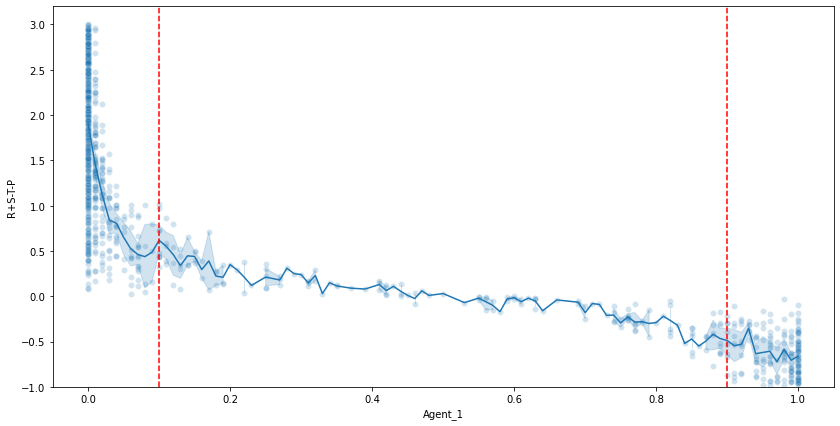

In [275]:
plt.figure(figsize=(14, 7))
df_SH['R+S-T-P'] = df_SH['reward'] + df_SH['sucker'] - df_SH['temptation'] - df_SH['punishment']
sns.lineplot(data=df_SH, x='Agent_1', y='R+S-T-P')
sns.scatterplot(data=df_SH, x='Agent_1', y='R+S-T-P', alpha=0.2)
plt.vlines(0.1, -1, 10, 'r', '--')
plt.vlines(0.9, -1, 10, 'r', '--')
plt.ylim(-1,3.2)

In [246]:
df_SH_theor = pd.DataFrame(columns=['Cooperaion', 'Defection', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, S, T, P = val, SUCKER[idx], TEMPTATION[idx], PUNISHMENT[idx]
    Pr = 0
    for i in range(11):
        if (R+S) * binom.cdf(i, 10, 0.5) < (T+P) * (1-binom.cdf(i, 10, 0.5)):
            if (R+S) * binom.cdf(i+1, 10, 0.5) > (T+P) * (1-binom.cdf(i+1, 10, 0.5)):
                df_SH_theor.loc[len(df_SH_theor.index)]=[1-binom.cdf(i, 10, 0.5), binom.cdf(i, 10, 0.5), T,R,P,S]
            if i > 9:
                df_SH_theor.loc[len(df_SH_theor.index)]=[1-binom.cdf(i, 10, 0.5), binom.cdf(i, 10, 0.5), T,R,P,S]

1000it [00:02, 345.46it/s]


(-1.0, 3.2)

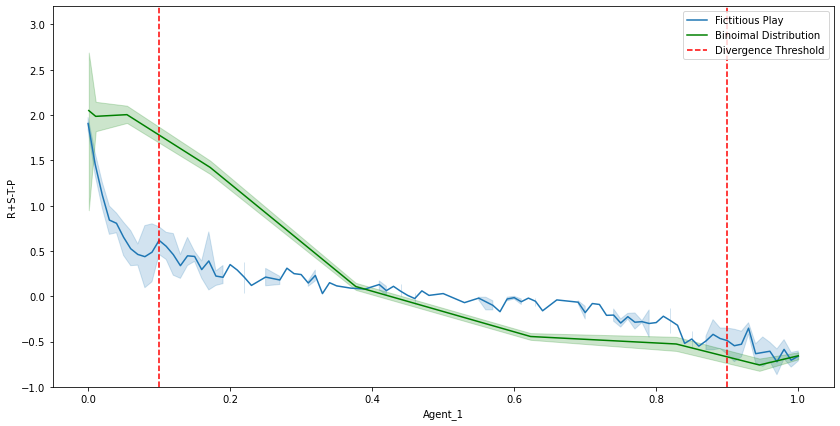

In [276]:
plt.figure(figsize=(14, 7))
df_SH['R+S-T-P'] = df_SH['reward'] + df_SH['sucker'] - df_SH['temptation'] - df_SH['punishment']
sns.lineplot(data=df_SH, x='Agent_1', y='R+S-T-P', label='Fictitious Play')
# sns.scatterplot(data=df_SH, x='Agent_1', y='R+S-T-P', label='Fictitious Play', alpha=0.3)
df_SH_theor['R+S-T-P'] = df_SH_theor['reward'] + df_SH_theor['sucker'] - df_SH_theor['temptation'] - df_SH_theor['punishment']
sns.lineplot(data=df_SH_theor, x='Defection', y='R+S-T-P',color='green', label='Binoimal Distribution')
# sns.scatterplot(data=df_SH_theor, x='Defection', y='R+S-T-P', label='Fictitious Play', alpha=0.3)
plt.vlines(0.1, -1, 10, 'r', '--', label='Divergence Threshold')
plt.vlines(0.9, -1, 10, 'r', '--')
plt.legend()
plt.ylim(-1,3.2)

<AxesSubplot:xlabel='Agent_1', ylabel='R+S-T-P'>

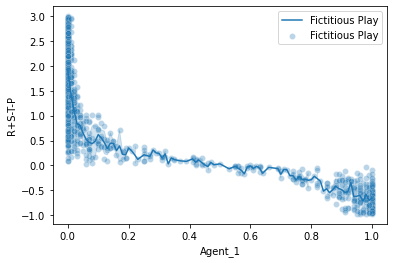

In [264]:
df_SH[df_SH['Agent_1'] == 0]
# df_SH_theor[df_SH_theor['Defection'] == 0]
sns.lineplot(data=df_SH, x='Agent_1', y='R+S-T-P', label='Fictitious Play')
sns.scatterplot(data=df_SH, x='Agent_1', y='R+S-T-P', label='Fictitious Play', alpha=0.3)


(0.0, 2.0)

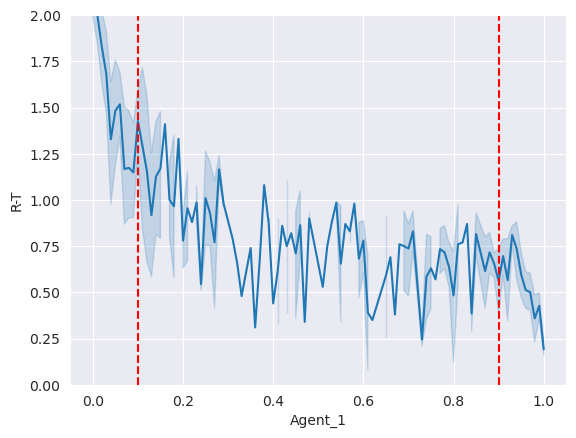

In [10]:
df_SH_convergent = df_SH.where((df_SH['Agent_1'] >= 0.9) | (df_SH['Agent_1'] <= 0.1)).dropna()
df_SH['R-T'] = df_SH['reward'] - df_SH['temptation']
sns.lineplot(data=df_SH, x='Agent_1', y='R-T')
plt.vlines(0.1, -0, 3.5, 'r', '--')
plt.vlines(0.9, -0, 3.5, 'r', '--')
plt.ylim(0,2)

In [11]:
df_SH.where((df_SH['Agent_1'] < 0.9) & (df_SH['Agent_1'] > 0.1)).dropna()

,Agent_1,Agent_2,Agent_1_Belief,Agent_2_Belief,temptation,reward,punishment,sucker,R+S-T-P,R-T
4,0.59,0.59,0.580404,0.579091,0.04,1.00,0.0,-1.03,-0.07,0.96
15,0.88,0.88,0.841717,0.843939,0.38,1.00,0.0,-1.22,-0.60,0.62
18,0.88,0.88,0.842424,0.843939,0.15,1.00,0.0,-1.39,-0.54,0.85
24,0.11,0.11,0.147172,0.151010,0.12,1.53,0.0,-0.88,0.53,1.41
25,0.27,0.27,0.290909,0.293030,0.86,1.05,0.0,-0.14,0.05,0.19
...,...,...,...,...,...,...,...,...,...,...
987,0.23,0.23,0.256263,0.257677,0.31,1.30,0.0,-0.69,0.30,0.99
991,0.51,0.51,0.506061,0.507071,0.47,1.00,0.0,-0.63,-0.10,0.53
992,0.57,0.57,0.562828,0.563131,0.11,1.00,0.0,-1.01,-0.12,0.89
995,0.60,0.60,0.591919,0.590404,0.10,1.00,0.0,-0.99,-0.09,0.90


(-1.0, 2.0)

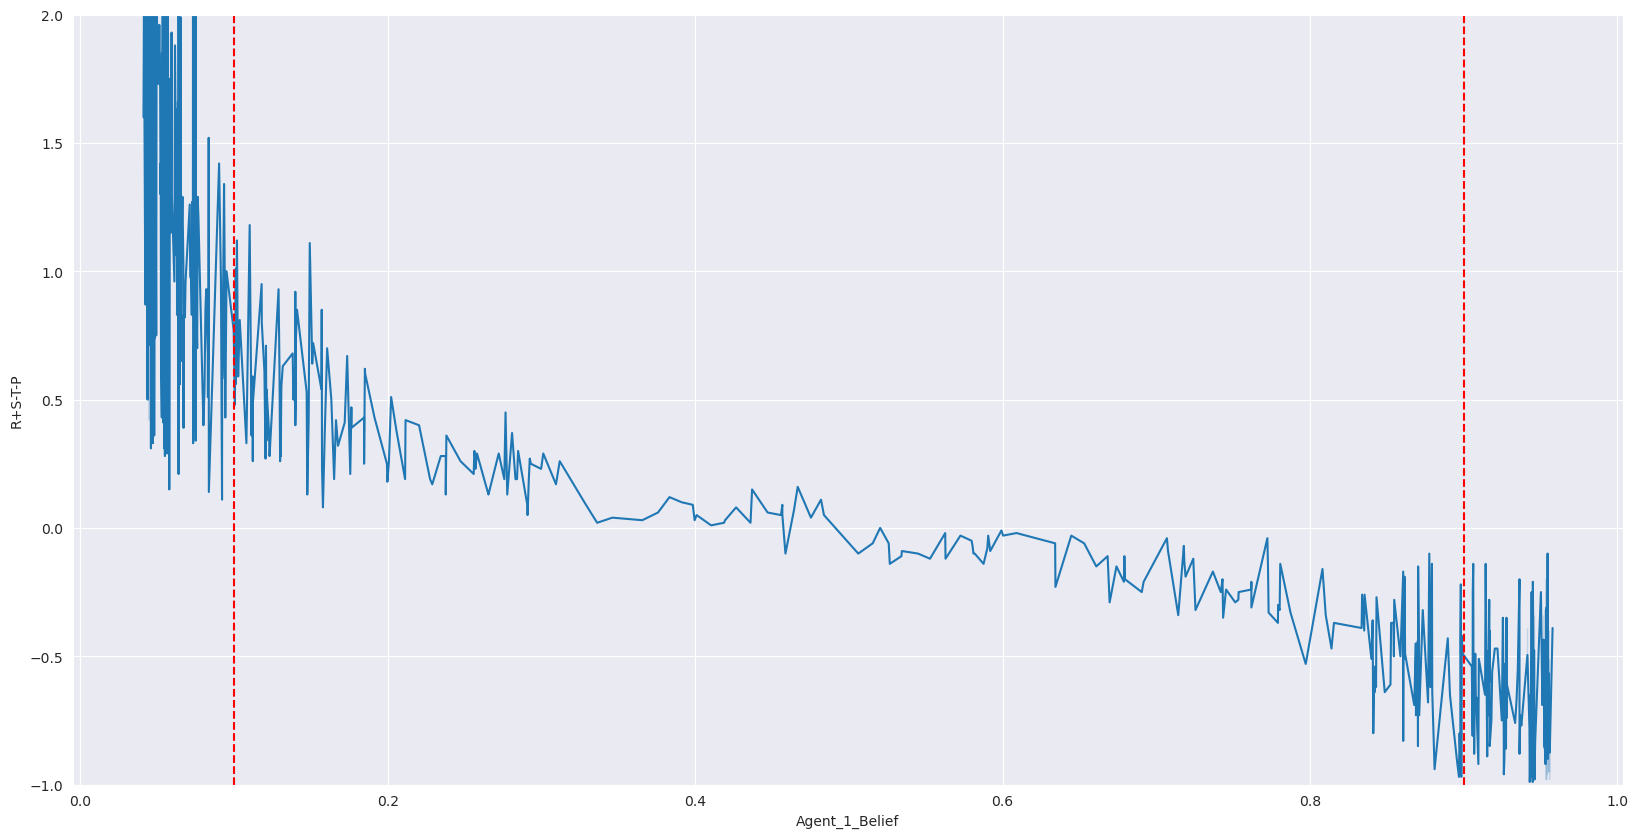

In [12]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_SH, x='Agent_1_Belief', y='R+S-T-P')
plt.vlines(0.1, -1, 3.5, 'r', '--')
plt.vlines(0.9, -1, 3.5, 'r', '--')
plt.ylim(-1,2)

(-0.5, 1.5)

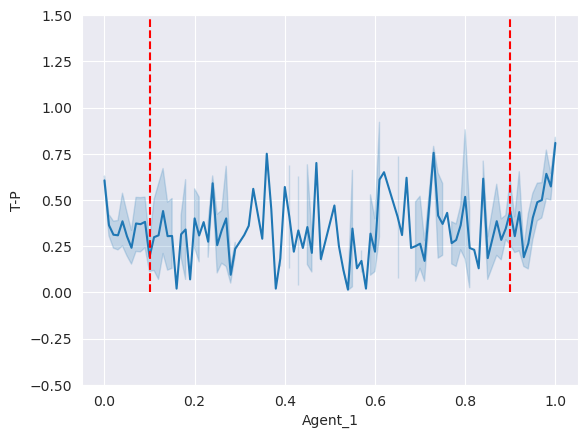

In [13]:
df_SH['T-P'] = df_SH['temptation'] - df_SH['punishment']
sns.lineplot(data=df_SH, x='Agent_1', y='T-P')
plt.vlines(0.1, -0, 10, 'r', '--')
plt.vlines(0.9, -0, 10, 'r', '--')
plt.ylim(-0.5,1.5)

(0.0, 2.0)

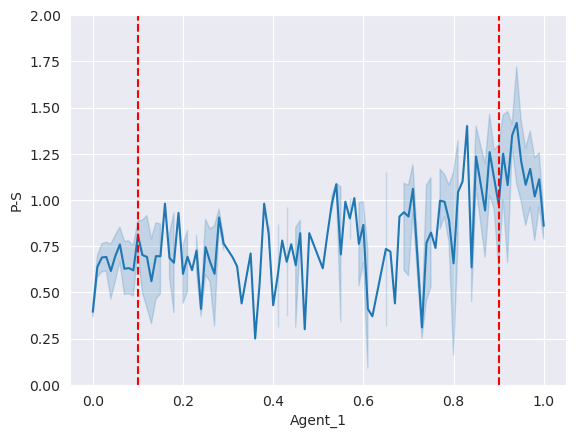

In [14]:
df_SH['P-S'] = df_SH['punishment'] - df_SH['sucker']
sns.lineplot(data=df_SH, x='Agent_1', y='P-S')
plt.vlines(0.1, -0, 10, 'r', '--')
plt.vlines(0.9, -0, 10, 'r', '--')
plt.ylim(0,2)

### Generalized into N-Agent Version

In [15]:
def multi_agent_fictitious_play(N_EPISODES:int, payoff:Type.TensorType, reward:Type.TensorType, strategy:Type.TensorType, belief:Type.TensorType, N:int, alpha:float=0.05, epsilon:float=0.05, entropy_flag:bool=False):

    def entropy(p:float):
        return -np.sum(p * np.log(p + 1e-6))

    def random_select_partner(N:int, n:int):
        m = n
        while m == n:
            m = np.random.randint(0, N)
        return m

    def select_partner_entropy(N:int, n:int, belief:Type.TensorType):
        min_en = np.inf
        m = 0
        for i in range(N):
            if i == n:
                continue
            en = entropy(belief.copy()[i])
            if en < min_en:
                min_en= en
                m = i
        return m

    assert strategy.shape == (N_EPISODES, N), f"strategy columns should be {N}, but {strategy.shape}"

    log=dict()
    final_strategy = np.zeros(N)
    # exploration
    for i in range(1,10):
        n = np.random.randint(0, N)
        m = random_select_partner(N,n)

        strategy[i,n] = np.random.randint(0,2)
        strategy[i,m] = np.random.randint(0,2)

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}

    for i in range(10,N_EPISODES):
        n = np.random.randint(0, N)

        if entropy_flag:
            m = select_partner_entropy(N,n,belief)
        else:
            m = random_select_partner(N,n)

        # calculate payoff of Agent 1 assuming the other Agent plays according to empirical dist.
        reward[0,0] = belief[n]*payoff[0,1] + (1-belief[n])*payoff[0,0]
        reward[1,0] = belief[n]*payoff[1,1] + (1-belief[n])*payoff[1,0]

        # calculate payoff of Agent 2 assuming the other Agent plays according to empirical dist.
        reward[0,1] = belief[m]*payoff[0,1] + (1-belief[m])*payoff[0,0]
        reward[1,1] = belief[m]*payoff[1,1] + (1-belief[m])*payoff[1,0]

        # Agent 1's best response
        if reward[0,0] < reward[1,0]-epsilon:
            strategy[i,n] = 1
        elif reward[0,0]-epsilon > reward[1,0]:
            strategy[i,n] = 0
        else:
            strategy[i,n] = np.random.randint(0,2)

        # Agent 2's best response
        if  reward[0,1] < reward[1,1]-epsilon:
            strategy[i,m] = 1
        elif reward[0,1]-epsilon > reward[1,1]:
            strategy[i,m] = 0
        else:
            strategy[i,m] = np.random.randint(0,2)

        print('error') if strategy[i,n]<0 or strategy[i,m]<0 else None

        # update the empirical distribution
        belief[n] = (1-alpha)*belief[n] + alpha*strategy[i,n]
        belief[m] = (1-alpha)*belief[m] + alpha*strategy[i,m]
        log[i] = {n:belief[n],m:belief[m]}
        # store the (normalized) number of iterations
        # strategy[i,2] = i/N_EPISODES
        # belief[i,2] = i/N_EPISODES
    for i in range(N):
        j = -1
        while strategy[j,i] == -1:
            j -= 1
        final_strategy[i] = strategy[j,i]
    return strategy, belief, log, final_strategy

In [16]:
def multi_stimulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT, N_EPISODES, N_AGENTS, EPOCH, entropy_flag=False):
    payoff = np.array([[REWARD, SUCKER],[TEMPTATION, PUNISHMENT]])
    strategy_list, belief_list = [],[]
    for ep in range(EPOCH):
        # 'reward' stores the payoff for each player, assuming the other player plays according to the empirical distribution
        reward = np.zeros([2,2])
        # 'strategy' stores the strategy played in each time period
        strategy = -np.ones([N_EPISODES,N_AGENTS])
        # 'belief' stores the empirical distribution at each time period, which is the defection probability
        belief = np.zeros(N_AGENTS)
        _, belief, belief_log, final_strategy = multi_agent_fictitious_play(N_EPISODES, payoff, reward, strategy, belief, N_AGENTS, entropy_flag=entropy_flag)
        strategy_list.append(final_strategy.copy())
        belief_list.append(belief.copy())

    columns = []
    for i in range(N_AGENTS):
        columns.append(f'Agent_{i+1}')
    for i in range(N_AGENTS):
        columns.append(f'Agent_{i+1}_Belief')

    df = pd.DataFrame(np.concatenate((np.array(strategy_list),np.array(belief_list)), axis=1), columns=columns)
    return df

random partner selection

In [17]:
# prisoner's dilemma
REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3.0, 5.8, 0.1, 3.3	
# stag hunt
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 3, 0, 1
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 4, 4, 0, 1
# chicken
# REWARD, TEMPTATION, SUCKER, PUNISHMENT = 3, 4, 1, 0

EPOCH = 100
N_AGENTS = 3
N_EPISODES = 1000
# C:0, D:1
# payoff matrix for the two players in the 2x2 game
df_multi_PD = multi_stimulate(REWARD, TEMPTATION, SUCKER, PUNISHMENT, N_EPISODES, N_AGENTS, EPOCH)
df_multi_PD.describe()

,Agent_1,Agent_2,Agent_3,Agent_1_Belief,Agent_2_Belief,Agent_3_Belief
count,100.0,100.0,100.0,1.000000e+02,1.000000e+02,1.000000e+02
mean,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
std,0.0,0.0,0.0,2.079942e-15,1.815697e-15,1.979151e-15
min,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
50%,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
75%,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
max,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00


100it [03:57,  2.38s/it]


<AxesSubplot:ylabel='Frequency'>

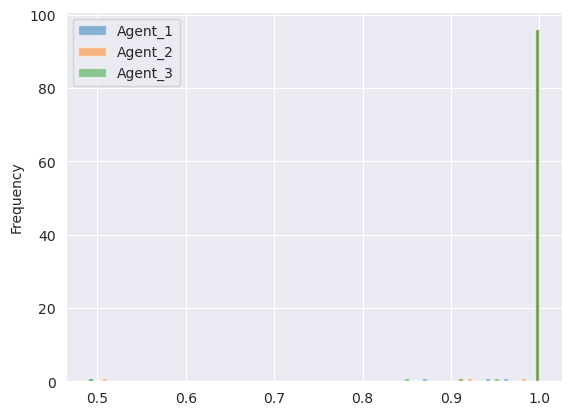

In [18]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
df_multi_PD = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_3', 'Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
df_multi_PD = df_multi_PD.astype(float)
df_multi_PD[['Agent_1', 'Agent_2', 'Agent_3']].plot.hist(bins=100, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

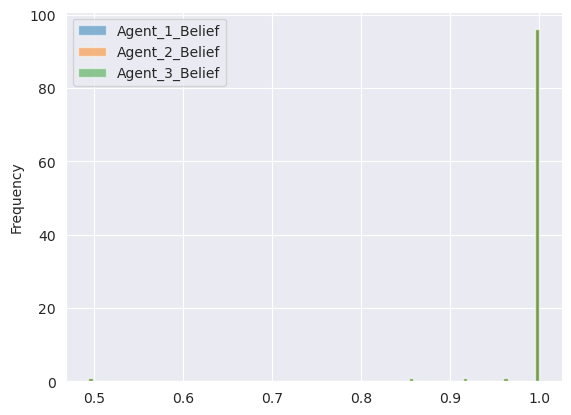

In [19]:
df_multi_PD[['Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief']].plot.hist(bins=100, alpha=0.5)

In [20]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
for N in range(4,10):
    df_multi_PD = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
        df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
    df_multi_PD = df_multi_PD.astype(float)
    if sum(df_multi_PD['Agent_1'] < 0.9) >= 10 or sum(df_multi_PD['Agent_1_Belief'] < 0.9) >= 10:
        print(df_multi_PD.mean())

100it [03:44,  2.24s/it]
100it [03:39,  2.19s/it]
100it [03:37,  2.17s/it]
100it [03:36,  2.16s/it]
100it [03:34,  2.14s/it]
100it [03:33,  2.14s/it]


In [21]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
df_multi_SH = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_SH = pd.concat([df_multi_SH, df_mean], ignore_index=True)
df_multi_SH = df_multi_SH.astype(float)
df_multi_SH.describe()

1000it [40:44,  2.44s/it]


,temptation,reward,punishment,sucker,Agent_1,Agent_2,Agent_3,Agent_1_Belief,Agent_2_Belief,Agent_3_Belief
count,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.00000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.500900,1.878840,0.0,-0.646680,0.044820,0.04537,0.045210,4.482511e-02,4.535109e-02,4.522641e-02
std,0.282772,0.842436,0.0,0.390051,0.176355,0.17765,0.177041,1.763694e-01,1.775743e-01,1.771171e-01
min,0.010000,1.000000,0.0,-1.870000,0.000000,0.00000,0.000000,2.448188e-16,2.559919e-16,2.587325e-16
25%,0.260000,1.000000,0.0,-0.892500,0.000000,0.00000,0.000000,3.256829e-16,3.258264e-16,3.252705e-16
50%,0.510000,1.690000,0.0,-0.630000,0.000000,0.00000,0.000000,3.514919e-16,3.535746e-16,3.543721e-16
75%,0.740000,2.670000,0.0,-0.350000,0.000000,0.00000,0.000000,3.885615e-16,3.901436e-16,3.906025e-16
max,0.990000,3.500000,0.0,-0.010000,1.000000,1.00000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


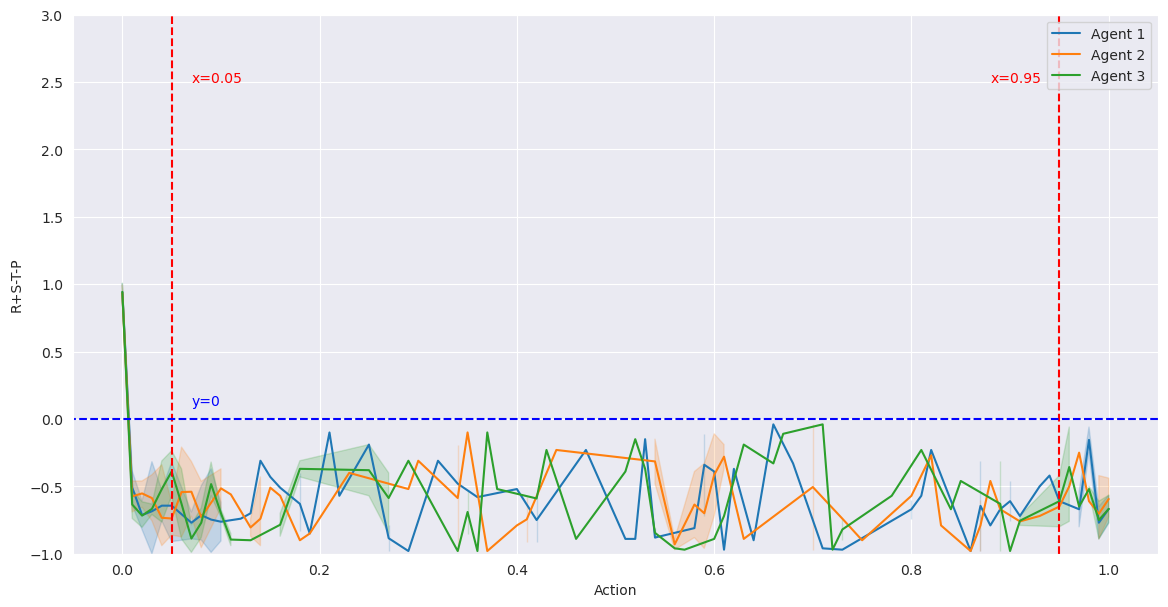

In [22]:
plt.figure(figsize=(14, 7))
df_multi_SH['R+S-T-P'] = df_multi_SH['reward'] + df_multi_SH['sucker'] - df_multi_SH['temptation'] - df_multi_SH['punishment']
sns.lineplot(data=df_multi_SH, x='Agent_1', y='R+S-T-P', label='Agent 1')
sns.lineplot(data=df_multi_SH, x='Agent_2', y='R+S-T-P', label='Agent 2')
sns.lineplot(data=df_multi_SH, x='Agent_3', y='R+S-T-P', label='Agent 3')
plt.vlines(0.05, -1, 10, 'r', '--')
plt.vlines(0.95, -1, 10, 'r', '--')
plt.hlines(0, -0.1, 1.1, 'b', '--')
plt.ylim(-1,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.1, "y=0", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.xlabel('Action')
plt.legend()

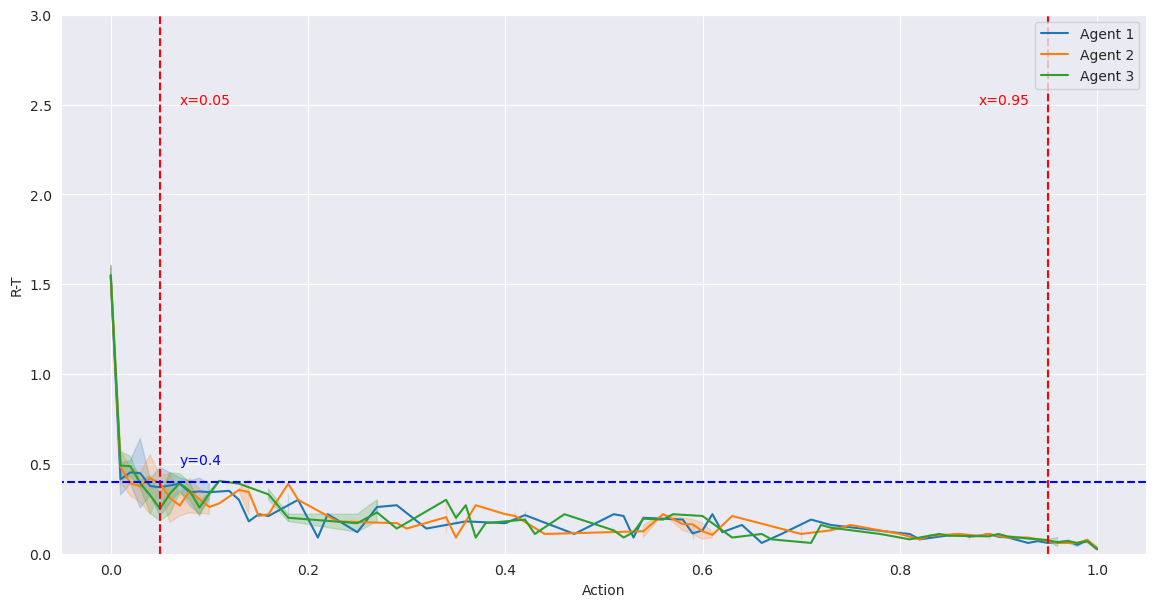

In [23]:
plt.figure(figsize=(14, 7))
df_multi_SH['R-T'] = df_multi_SH['reward'] - df_multi_SH['temptation']
sns.lineplot(data=df_multi_SH, x='Agent_1', y='R-T', label='Agent 1')
sns.lineplot(data=df_multi_SH, x='Agent_2', y='R-T', label='Agent 2')
sns.lineplot(data=df_multi_SH, x='Agent_3', y='R-T', label='Agent 3')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.xlabel('Action')
plt.legend()

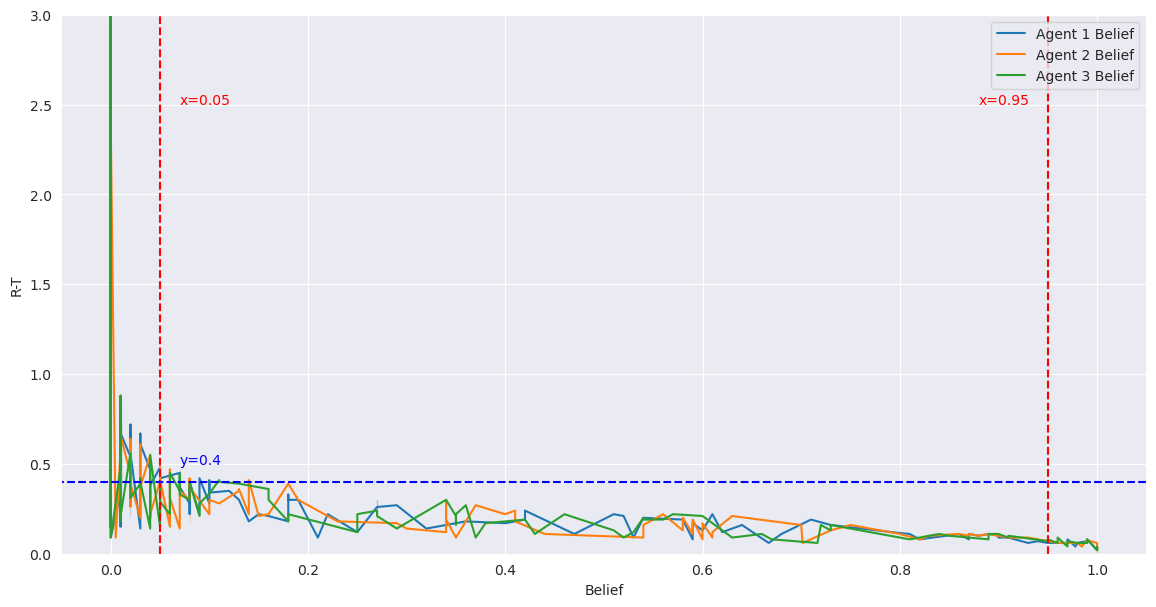

In [24]:
plt.figure(figsize=(14, 7))
df_multi_SH['R-T'] = df_multi_SH['reward'] - df_multi_SH['temptation']
sns.lineplot(data=df_multi_SH, x='Agent_1_Belief', y='R-T', label='Agent 1 Belief')
sns.lineplot(data=df_multi_SH, x='Agent_2_Belief', y='R-T', label='Agent 2 Belief')
sns.lineplot(data=df_multi_SH, x='Agent_3_Belief', y='R-T', label='Agent 3 Belief')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.xlabel('Belief')
plt.legend()

Select partner according to entropy

100it [07:30,  4.51s/it]


<AxesSubplot:ylabel='Frequency'>

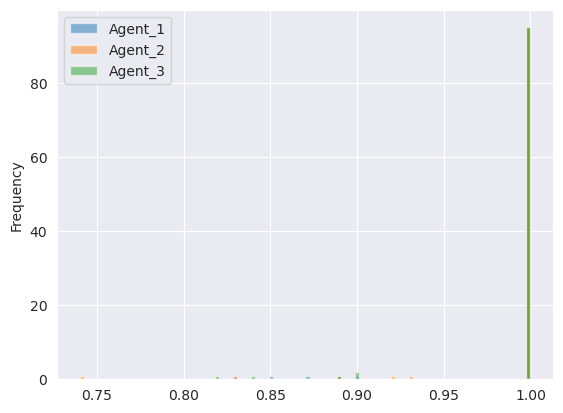

In [25]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('PD', N=100)
df_multi_PD_entropy = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH, entropy_flag=True)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_PD_entropy = pd.concat([df_multi_PD_entropy, df_mean], ignore_index=True)
df_multi_PD_entropy = df_multi_PD_entropy.astype(float)
df_multi_PD_entropy[['Agent_1', 'Agent_2', 'Agent_3']].plot.hist(bins=100, alpha=0.5)

In [26]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=1000)
df_multi_SH_entropy = pd.DataFrame(columns=['Agent_1', 'Agent_2', 'Agent_3', 'Agent_1_Belief', 'Agent_2_Belief', 'Agent_3_Belief', 'temptation', 'reward', 'punishment', 'sucker'])
for idx, val in tqdm(enumerate(REWARD)):
    R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
    df = multi_stimulate(R, T, S, P, N_EPISODES, N_AGENTS, EPOCH, entropy_flag=True)
    df_mean = df.mean().to_frame().transpose()
    df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
    df_multi_SH_entropy = pd.concat([df_multi_SH_entropy, df_mean], ignore_index=True)
df_multi_SH_entropy = df_multi_SH_entropy.astype(float)

1000it [1:15:24,  4.52s/it]


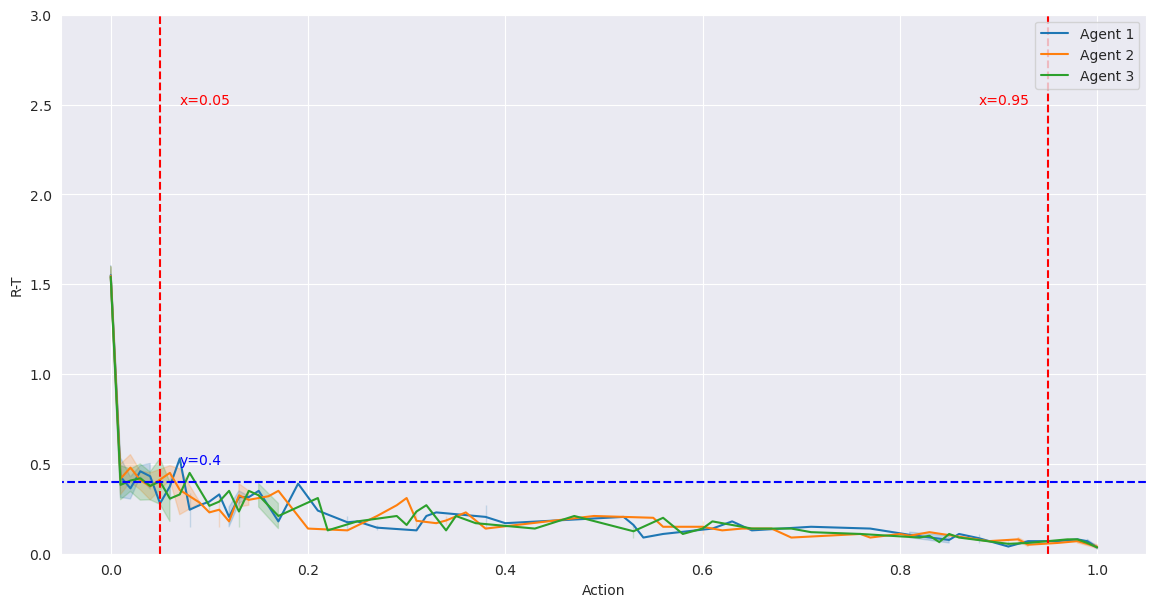

In [27]:
plt.figure(figsize=(14, 7))
df_multi_SH_entropy['R-T'] = df_multi_SH_entropy['reward'] - df_multi_SH_entropy['temptation']
sns.lineplot(data=df_multi_SH_entropy, x='Agent_1', y='R-T', label='Agent 1')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_2', y='R-T', label='Agent 2')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_3', y='R-T', label='Agent 3')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.legend()
plt.xlabel('Action')
plt.show()

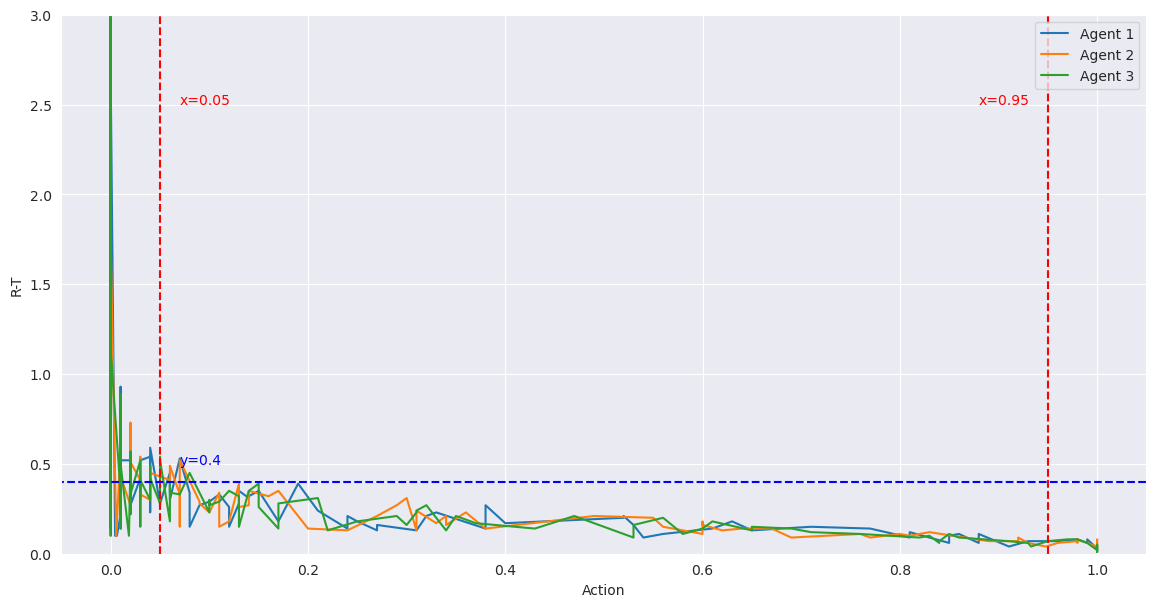

In [28]:
plt.figure(figsize=(14, 7))
df_multi_SH_entropy['R-T'] = df_multi_SH_entropy['reward'] - df_multi_SH_entropy['temptation']
sns.lineplot(data=df_multi_SH_entropy, x='Agent_1_Belief', y='R-T', label='Agent 1')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_2_Belief', y='R-T', label='Agent 2')
sns.lineplot(data=df_multi_SH_entropy, x='Agent_3_Belief', y='R-T', label='Agent 3')
plt.vlines(0.05, -0, 10, 'r', '--')
plt.vlines(0.95, -0, 10, 'r', '--')
plt.hlines(0.4, -0.1, 1.1, 'b', '--')
plt.ylim(0,3)
plt.xlim(-0.05,1.05)
plt.text(0.07, 0.5, "y=0.4", c='blue')
plt.text(0.07, 2.5, "x=0.05", c='red')
plt.text(0.88, 2.5, "x=0.95", c='red')
plt.legend()
plt.xlabel('Action')
plt.show()

In [29]:
REWARD, TEMPTATION, SUCKER, PUNISHMENT = generate_payoff_matrix('SH', N=100)
for N in range(4,10):
    df_multi_PD = pd.DataFrame(columns=['temptation', 'reward', 'punishment', 'sucker'])
    for idx, val in tqdm(enumerate(REWARD)):
        R, T, S, P = val, TEMPTATION[idx], SUCKER[idx], PUNISHMENT[idx]
        df = multi_stimulate(R, T, S, P, N_EPISODES, N, EPOCH)
        df_mean = df.mean().to_frame().transpose()
        df_mean['temptation'], df_mean['reward'], df_mean['punishment'], df_mean['sucker'] = T, R, P, S
        df_multi_PD = pd.concat([df_multi_PD, df_mean], ignore_index=True)
    df_multi_PD = df_multi_PD.astype(float)
    print(df_multi_PD.mean())

100it [03:54,  2.35s/it]


temptation        0.5296
reward            1.9330
punishment        0.0000
sucker           -0.6137
Agent_1           0.0503
Agent_2           0.0478
Agent_3           0.0486
Agent_4           0.0466
Agent_1_Belief    0.0503
Agent_2_Belief    0.0478
Agent_3_Belief    0.0486
Agent_4_Belief    0.0466
dtype: float64


100it [03:51,  2.32s/it]


temptation        0.5296
reward            1.9330
punishment        0.0000
sucker           -0.6137
Agent_1           0.0431
Agent_2           0.0439
Agent_3           0.0446
Agent_4           0.0421
Agent_5           0.0445
Agent_1_Belief    0.0431
Agent_2_Belief    0.0439
Agent_3_Belief    0.0446
Agent_4_Belief    0.0421
Agent_5_Belief    0.0445
dtype: float64


100it [03:46,  2.27s/it]


temptation        0.5296
reward            1.9330
punishment        0.0000
sucker           -0.6137
Agent_1           0.0394
Agent_2           0.0387
Agent_3           0.0412
Agent_4           0.0411
Agent_5           0.0406
Agent_6           0.0385
Agent_1_Belief    0.0394
Agent_2_Belief    0.0387
Agent_3_Belief    0.0412
Agent_4_Belief    0.0411
Agent_5_Belief    0.0406
Agent_6_Belief    0.0385
dtype: float64


100it [03:44,  2.25s/it]


temptation        0.5296
reward            1.9330
punishment        0.0000
sucker           -0.6137
Agent_1           0.0381
Agent_2           0.0383
Agent_3           0.0392
Agent_4           0.0384
Agent_5           0.0392
Agent_6           0.0385
Agent_7           0.0389
Agent_1_Belief    0.0381
Agent_2_Belief    0.0383
Agent_3_Belief    0.0392
Agent_4_Belief    0.0384
Agent_5_Belief    0.0392
Agent_6_Belief    0.0385
Agent_7_Belief    0.0389
dtype: float64


100it [03:44,  2.24s/it]


temptation        0.529600
reward            1.933000
punishment        0.000000
sucker           -0.613700
Agent_1           0.036500
Agent_2           0.037300
Agent_3           0.036600
Agent_4           0.036400
Agent_5           0.036200
Agent_6           0.037600
Agent_7           0.035500
Agent_8           0.036800
Agent_1_Belief    0.036500
Agent_2_Belief    0.037300
Agent_3_Belief    0.036600
Agent_4_Belief    0.036400
Agent_5_Belief    0.036199
Agent_6_Belief    0.037600
Agent_7_Belief    0.035500
Agent_8_Belief    0.036800
dtype: float64


100it [03:43,  2.23s/it]

temptation        0.529600
reward            1.933000
punishment        0.000000
sucker           -0.613700
Agent_1           0.035800
Agent_2           0.034500
Agent_3           0.036500
Agent_4           0.034400
Agent_5           0.036300
Agent_6           0.035800
Agent_7           0.035400
Agent_8           0.035600
Agent_9           0.035600
Agent_1_Belief    0.035795
Agent_2_Belief    0.034491
Agent_3_Belief    0.036499
Agent_4_Belief    0.034400
Agent_5_Belief    0.036298
Agent_6_Belief    0.035799
Agent_7_Belief    0.035398
Agent_8_Belief    0.035599
Agent_9_Belief    0.035599
dtype: float64
